# Low-rank Neural Operator

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import time
from timeit import default_timer
from Utilities_Laplace import MatReader
from utilities import EarlyStopping, DenseNet, GaussianNormalizer, UnitGaussianNormalizer
from functools import reduce
import operator
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [2]:
class LowRank2d(nn.Module):
    def __init__(self, in_channels, out_channels, s, width, rank):
        super(LowRank2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.s = s
        self.n = s*s
        self.rank = rank

        self.phi = DenseNet([3, 64, 128, 256, width*width*rank], torch.nn.ReLU)
        self.psi = DenseNet([3, 64, 128, 256, width*width*rank], torch.nn.ReLU)


    def forward(self, v, a):
        # a (batch, n, 3)
        # v (batch, n, f)
        batch_size = v.shape[0]

        phi_eval = self.phi(a).reshape(batch_size, self.n, self.out_channels, self.in_channels, self.rank)
        psi_eval = self.psi(a).reshape(batch_size, self.n, self.out_channels, self.in_channels, self.rank)

        # print(psi_eval.shape, v.shape, phi_eval.shape)
        v = torch.einsum('bnoir,bni,bmoir->bmo', psi_eval, v, phi_eval) / self.n

        return v



class MyNet(torch.nn.Module):
    def __init__(self, s, width=32, rank=1):
        super(MyNet, self).__init__()
        self.s = s
        self.width = width
        self.rank = rank

        self.fc0 = nn.Linear(3, self.width)

        self.net1 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.net2 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.net3 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.net4 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.w1 = nn.Linear(self.width, self.width)
        self.w2 = nn.Linear(self.width, self.width)
        self.w3 = nn.Linear(self.width, self.width)
        self.w4 = nn.Linear(self.width, self.width)

        self.bn1 = torch.nn.BatchNorm1d(self.width)
        self.bn2 = torch.nn.BatchNorm1d(self.width)
        self.bn3 = torch.nn.BatchNorm1d(self.width)
        self.bn4 = torch.nn.BatchNorm1d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)


    def forward(self, v):
        batch_size, n = v.shape[0], v.shape[1]
        a = v.clone()

        v = self.fc0(v)

        v1 = self.net1(v, a)
        v2 = self.w1(v)
        v = v1+v2
        v = self.bn1(v.reshape(-1, self.width)).view(batch_size,n,self.width)
        v = F.relu(v)

        v1 = self.net2(v, a)
        v2 = self.w2(v)
        v = v1+v2
        v = self.bn2(v.reshape(-1, self.width)).view(batch_size,n,self.width)
        v = F.relu(v)

        v1 = self.net3(v, a)
        v2 = self.w3(v)
        v = v1+v2
        v = self.bn3(v.reshape(-1, self.width)).view(batch_size,n,self.width)
        v = F.relu(v)

        v1 = self.net4(v, a)
        v2 = self.w4(v)
        v = v1+v2
        v = self.bn4(v.reshape(-1, self.width)).view(batch_size,n,self.width)


        v = self.fc1(v)
        v = F.relu(v)
        v = self.fc2(v)

        return v.squeeze()

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

Define parameters and Load data

In [ ]:
ntrain = 800
nvali = 100
ntest = 100

batch_size = 4

learning_rate = 0.0001
epochs = 1000
step_size = 100
gamma=0.5

reader = MatReader('data/2D_Burger.mat')
T = reader.read_field('t')
X = reader.read_field('x')

In [4]:
T.shape,X.shape

(torch.Size([1, 50]), torch.Size([1, 64]))

In [5]:
x_train = reader.read_field('f_train')[:ntrain,:50:,:50]
y_train = reader.read_field('u_train')[:ntrain,:50:,:50]
x_train.shape,y_train.shape

(torch.Size([800, 50, 50]), torch.Size([800, 50, 50]))

In [6]:
x_vali = reader.read_field('f_vali')[:nvali,:50,:50]
y_vali = reader.read_field('u_vali')[:nvali,:50:,:50]
x_vali.shape,y_vali.shape

(torch.Size([100, 50, 50]), torch.Size([100, 50, 50]))

In [7]:
x_test = reader.read_field('f_test')[:ntest,:50,:50]
y_test = reader.read_field('u_test')[:ntest,:50,:50]
x_test.shape,y_test.shape

(torch.Size([100, 50, 50]), torch.Size([100, 50, 50]))

In [8]:
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_vali = x_normalizer.encode(x_vali)
x_test = x_normalizer.encode(x_test)

In [9]:
y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

In [11]:
r = 8.5
h = int((421 - 1)/r) + 1
s = h
print(s,h,r)

50 50 8.5


In [12]:

grids = []
grids.append(np.linspace(0, 1, s))
grids.append(np.linspace(0, 1, s))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = grid.reshape(1,s*s,2)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.cat([x_train.reshape(ntrain,s*s,1), grid.repeat(ntrain,1,1)], dim=2)
x_vali=torch.cat([x_vali.reshape(nvali,s*s,1), grid.repeat(nvali,1,1)], dim=2)
x_test = torch.cat([x_test.reshape(ntest,s*s,1), grid.repeat(ntest,1,1)], dim=2)

In [13]:
batch_size=4
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
vali_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_vali, y_vali), batch_size=batch_size, shuffle=False)


In [15]:
os.makedirs('models/lowrank2d', exist_ok=True)

Training

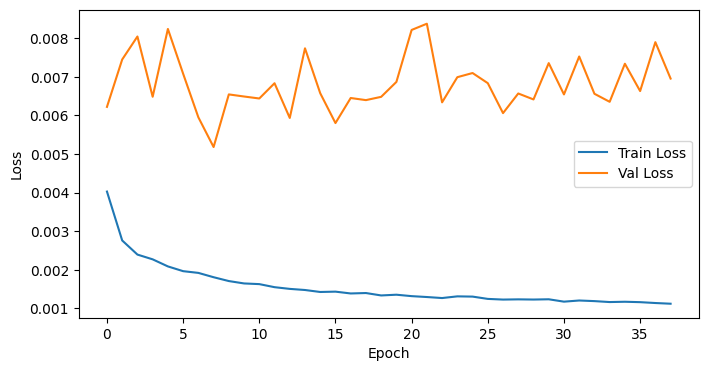

EarlyStopping counter: 30 out of 30
Epoch 037 | time 17.992s | train_mse 1.120576e-03 | val_mse: 6.956471e-03
We are at epoch: 37

Training done...
Training time: 680.497



In [ ]:
# model
model = MyNet(s).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
start_time = time.time()
mse=nn.MSELoss()
train_losses = []
val_losses = []

early_stopping = EarlyStopping(patience=30, verbose=True, path='models/lowrank2d/lowrank2d_checkpoint.pt', trace_func=print)
y_normalizer.cuda()

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x).reshape(-1,s,s)
        # mse = F.mse_loss(out.view(batch_size_train, -1), y.view(batch_size_train, -1), reduction='mean')
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        mse_loss = mse(out, y)
        mse_loss.backward()
        optimizer.step()
        train_mse += mse_loss.item()
        # train_l2 += l2.item()

    scheduler.step()
    model.eval()
    vali_mse = 0
    with torch.no_grad():
        for x, y in vali_loader:
            x, y = x.cuda(), y.cuda()
            out = model(x).reshape(-1,s,s)
            out = y_normalizer.decode(out)
            y = y_normalizer.decode(y)
            # mse=F.mse_loss(out.view(batch_size_vali, -1), y.view(batch_size_vali, -1), reduction='mean')
            vali_mse += mse(out, y).item()
           

    train_mse /= ntrain
    vali_mse /= nvali
    train_losses.append(train_mse)
    val_losses.append(vali_mse)
    t2 = default_timer()
   
    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # early stopping
    early_stopping(val_loss=vali_mse,model=model)
    print(f"Epoch {ep:03d} | time {t2-t1:.3f}s | train_mse {train_mse:.6e} | val_mse: {vali_mse:.6e}")
    if early_stopping.early_stop:
        print("We are at epoch:", ep)
        break

elapsed = time.time() - start_time
print("\n=============================")
print("Training done...")
print('Training time: %.3f'%(elapsed))
print("=============================\n")

In [19]:
mse_loss

tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward0>)

Evaluation & MEtrics

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os


# Ensure eval mode
model.eval()
preds = []
gts = []
rel_l2_list = []
mse_list = []
mae_list = []
rmse_list = []
r2_list = []
loss_data=[]

with torch.no_grad():
    for idx, (x, y) in enumerate(zip(x_test, y_test)):
        x= x.unsqueeze(0).cuda()
        y=y.unsqueeze(0).cuda()
        out = model(x).reshape(-1,s,s)
        out = y_normalizer.decode(out).cpu().numpy()
        y = y_normalizer.decode(y).cpu().numpy()
        gts.append(y)
        preds.append(out)
        mse = mean_squared_error(y.flatten(), out.flatten())
        mae = mean_absolute_error(y.flatten(), out.flatten())
        rmse = np.sqrt(mse)
        r2 = r2_score(y.flatten(), out.flatten())

        mse_list.append(mse)
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
        loss_data.append({'idx':idx, 'mse':mse, 'mae':mae, 'rmse':rmse, 'r2':r2})
        print(f"Sample {idx:3d} | MSE: {mse:.6e} | RMSE: {rmse:.6e} | MAE: {mae:.6e} | R2: {r2:.4f}")


# summary
def summarize(metric_list, name):
    arr = np.array(metric_list)
    print(f"{name:10s} => mean: {np.mean(arr):.6e}    std: {np.std(arr):.6e}    median: {np.median(arr):.6e}")

print("\\n=== Summary over test set ===")
summarize(rel_l2_list, "rel-L2")
summarize(mse_list,   "MSE")
summarize(rmse_list,  "RMSE")
summarize(mae_list,   "MAE")
summarize(r2_list,    "R2")

Sample   0 | MSE: 3.984459e-03 | RMSE: 6.312257e-02 | MAE: 5.437838e-02 | R2: -7.4501
Sample   1 | MSE: 3.946636e-02 | RMSE: 1.986614e-01 | MAE: 1.785033e-01 | R2: -7.0046
Sample   2 | MSE: 7.552344e-02 | RMSE: 2.748153e-01 | MAE: 2.295331e-01 | R2: -9.1830
Sample   3 | MSE: 1.100996e-02 | RMSE: 1.049284e-01 | MAE: 8.587566e-02 | R2: -11.1286
Sample   4 | MSE: 5.362880e-02 | RMSE: 2.315789e-01 | MAE: 2.009092e-01 | R2: -10.6350
Sample   5 | MSE: 2.675091e-02 | RMSE: 1.635571e-01 | MAE: 1.448044e-01 | R2: -5.9881
Sample   6 | MSE: 6.349112e-03 | RMSE: 7.968131e-02 | MAE: 7.063869e-02 | R2: -14.6635
Sample   7 | MSE: 1.300798e-02 | RMSE: 1.140525e-01 | MAE: 9.929797e-02 | R2: -8.5858
Sample   8 | MSE: 1.145559e-02 | RMSE: 1.070308e-01 | MAE: 9.507319e-02 | R2: -13.6095
Sample   9 | MSE: 2.565348e-02 | RMSE: 1.601670e-01 | MAE: 1.370730e-01 | R2: -6.3300
Sample  10 | MSE: 3.211121e-02 | RMSE: 1.791960e-01 | MAE: 1.667641e-01 | R2: -15.5919
Sample  11 | MSE: 1.090967e-02 | RMSE: 1.044494e-

/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [23]:
import pandas as pd
loss_df = pd.DataFrame(loss_data)

In [33]:
results={
    'mse':np.mean(mse_list),
    'rmse':np.mean(rmse_list),
    'mae':np.mean(mae_list),
    'r2':np.mean(r2_list),
    'pred': np.array(preds).reshape((-1,)+gts[0,0].shape), 'gts':np.array(gts.reshape((-1,)+gts[0,0].shape)),
    'rel_l2_list': np.array(rel_l2_list),
    'mse_list': np.array(mse_list),
    'mae_list': np.array(mae_list),
    'rmse_list': np.array(rmse_list),
    'r2_list': np.array(r2_list)
}
import pickle
pickle.dump(results, open('models/lowrank2d/burger_test_metrics.pickle', 'wb'))

In [34]:
results=pickle.load(open('models/lowrank2d/burger_test_metrics.pickle', 'rb'))

In [35]:
preds=results['pred']
gts=results['gts']

In [36]:
gts.shape, preds.shape

((100, 50, 50), (100, 50, 50))

In [37]:
min_loss_idx = loss_df[loss_df['mse'] == loss_df['mse'].min()]['idx'].values[0]
max_loss_idx = loss_df[loss_df['mse'] == loss_df['mse'].max()]['idx'].values[0]
min_loss_idx, max_loss_idx

(np.int64(42), np.int64(75))

In [38]:
def plot_comparison(idx):
    f,ax=plt.subplots(1,3,figsize=(15,5))
    plt.suptitle(f"Loss Comparison MSE: {loss_df.iloc[idx]['mse']:.6e}")
    ax[0].imshow(gts[idx].squeeze(), cmap='viridis')
    ax[0].set_title('Ground Truth')
    ax[1].imshow(preds[idx].squeeze(), cmap='viridis')
    ax[1].set_title('Prediction')
    ax[2].imshow(F.mse_loss(torch.tensor(gts[idx]),torch.tensor(preds[idx]),reduce=False).cpu().numpy(), cmap='bwr')
    ax[2].set_title('Error (MSE)')
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    plt.show()

/home/rusted/anaconda3/envs/neuralop/lib/python3.13/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


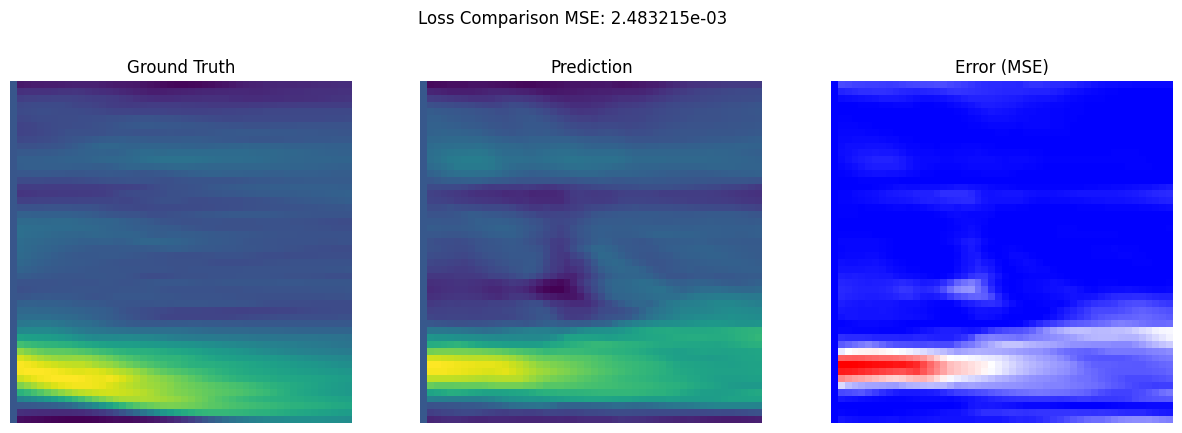

In [39]:
plot_comparison(min_loss_idx)

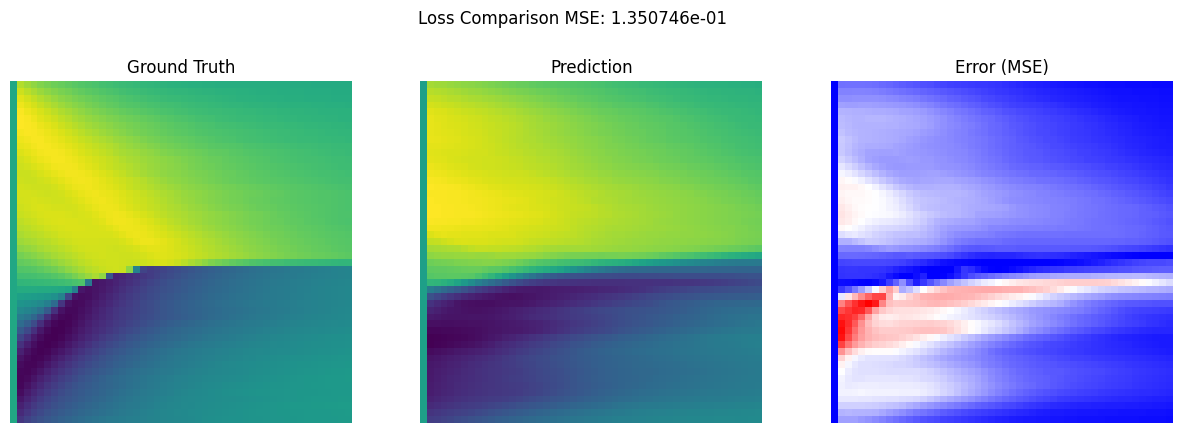

In [40]:
plot_comparison(max_loss_idx)
